⏳ Cargando dataset base...
✅ Dataset cargado. Dimensiones originales: (4486, 21)

⚙️ Iniciando Ingeniería de Features (Lags & Rolling Means)...
✅ Ingeniería completada. Nuevas dimensiones: (4425, 121)
   Variables generadas: 120 features + 1 target

🔬 Ejecutando Selección de Variables (Top 60 con Mutual Info)...


C:\Users\danny\AppData\Local\Temp\ipykernel_5008\1936711696.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eng[f'{col}_lag30'] = df_eng[col].shift(30) # Dato de hace un mes
C:\Users\danny\AppData\Local\Temp\ipykernel_5008\1936711696.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eng[f'{col}_roll_mean7'] = df_eng[col].rolling(window=7).mean().shift(1)
C:\Users\danny\AppData\Local\Temp\ipykernel_5008\1936711696.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

✅ Selección finalizada. Nos quedamos con 60 variables.


C:\Users\danny\AppData\Local\Temp\ipykernel_5008\1936711696.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=features_scores, palette='viridis')


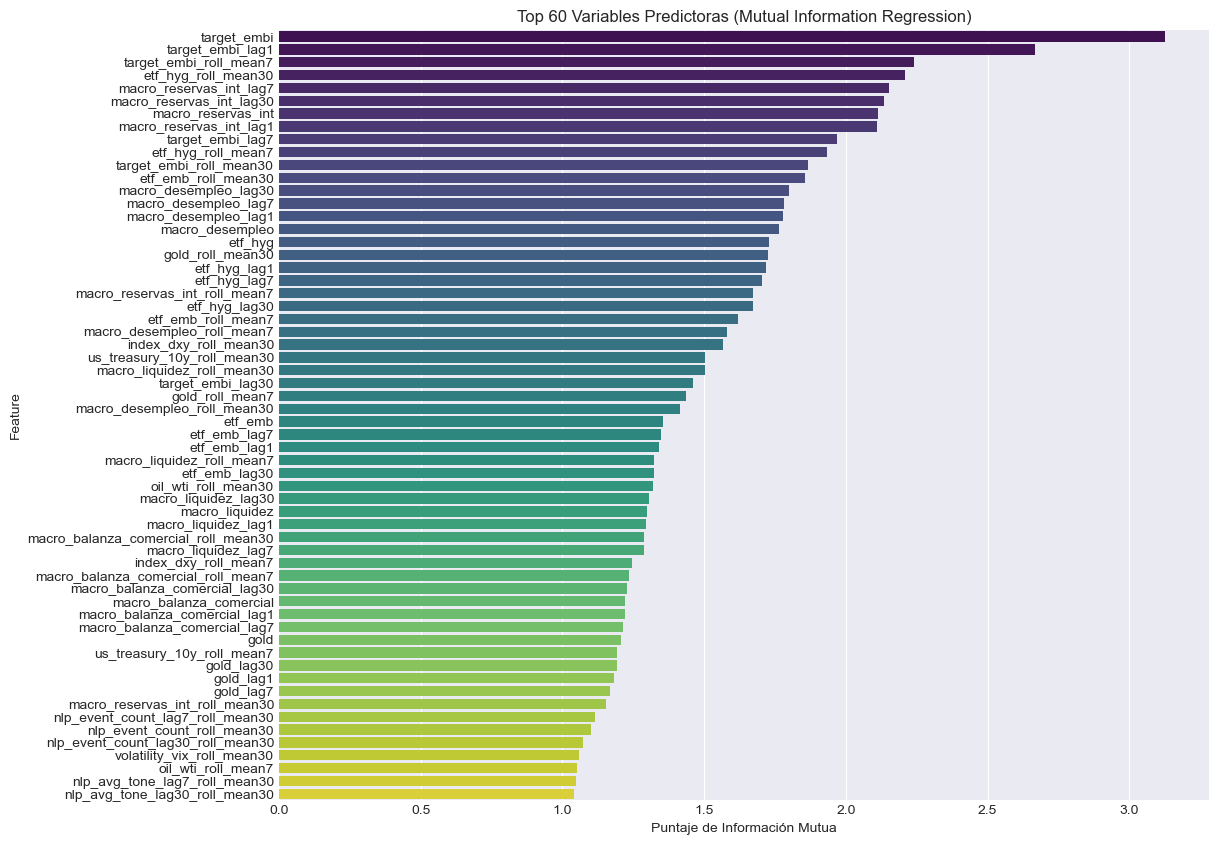


💾 Dataset procesado guardado exitosamente en: 'dataset_feature_engineered.pkl'
   Listo para el Notebook 04 (Modelado).


In [3]:
# =============================================================================
# 03_Feature_Engineering.ipynb
# =============================================================================
# Objetivo: Generación masiva de features (Lags/Rolling) y Selección (Filter Method)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Selección de Características
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')

# -----------------------------------------------------------------------------
# 1. CARGA DE DATOS
# -----------------------------------------------------------------------------
print("⏳ Cargando dataset base...")
try:
    # Cargamos el dataset limpio del paso 1
    df = pd.read_pickle('dataset_tesis_final.pkl')
    print(f"✅ Dataset cargado. Dimensiones originales: {df.shape}")
except FileNotFoundError:
    print("❌ Error: No se encuentra 'dataset_tesis_final.pkl'. Verifica la ruta.")

# -----------------------------------------------------------------------------
# 2. DEFINICIÓN DEL TARGET (Predecir t+1)
# -----------------------------------------------------------------------------
# Nuestro objetivo es predecir el EMBI de MAÑANA usando información de HOY.
# Por lo tanto, desplazamos la columna target hacia atrás una posición.
# La fila 't' tendrá las features de HOY y el target de MAÑANA.
df['target_future'] = df['target_embi'].shift(-1)

# -----------------------------------------------------------------------------
# 3. FEATURE ENGINEERING: Generación Masiva
# -----------------------------------------------------------------------------
print("\n⚙️ Iniciando Ingeniería de Features (Lags & Rolling Means)...")

# Identificamos las variables predictoras (todas menos el target futuro)
# Nota: Incluimos 'target_embi' (valor de hoy) porque es un predictor válido para mañana.
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target_future' in numeric_cols: numeric_cols.remove('target_future')

df_eng = df.copy()

# Bucle para generar variables derivadas para CADA columna numérica
for col in numeric_cols:
    # A. LAGS (Retardos): ¿Qué pasó hace 1 día, 1 semana, 1 mes?
    df_eng[f'{col}_lag1'] = df_eng[col].shift(1)   # Dato de ayer (t-1)
    df_eng[f'{col}_lag7'] = df_eng[col].shift(7)   # Dato de hace una semana
    df_eng[f'{col}_lag30'] = df_eng[col].shift(30) # Dato de hace un mes
    
    # B. ROLLING MEANS (Tendencias): ¿Cuál es el promedio reciente?
    # Usamos .shift(1) para asegurar que la media NO incluya el dato futuro (evitar data leakage)
    df_eng[f'{col}_roll_mean7'] = df_eng[col].rolling(window=7).mean().shift(1)
    df_eng[f'{col}_roll_mean30'] = df_eng[col].rolling(window=30).mean().shift(1)

# Limpieza de Nulos generados por los lags (perderemos los primeros 30 días + última fila)
df_eng = df_eng.dropna()

print(f"✅ Ingeniería completada. Nuevas dimensiones: {df_eng.shape}")
print(f"   Variables generadas: {len(df_eng.columns) - 1} features + 1 target")

# -----------------------------------------------------------------------------
# 4. SELECCIÓN DE VARIABLES (FILTER METHOD)
# -----------------------------------------------------------------------------
# Usaremos Mutual Information: detecta dependencias lineales Y no lineales.
# Queremos la mitad de las variables generadas que más "información" dan sobre el target.

N_FEATURES = 60

print(f"\n🔬 Ejecutando Selección de Variables (Top {N_FEATURES} con Mutual Info)...")

# Separar X (Features) e y (Target)
X = df_eng.drop(columns=['target_future'])
y = df_eng['target_future']

# Configuramos el Selector
selector = SelectKBest(score_func=mutual_info_regression, k=N_FEATURES)

# Entrenamos el selector (esto calcula la relevancia de cada columna)
# Nota: Esto puede tardar unos segundos
selector.fit(X, y)

# Obtenemos las columnas seleccionadas
cols_idxs = selector.get_support(indices=True)
selected_features = X.columns[cols_idxs].tolist()

# Creamos el Dataset Final Reducido
X_selected = X[selected_features]
df_final_selected = pd.concat([X_selected, y], axis=1)

print(f"✅ Selección finalizada. Nos quedamos con {X_selected.shape[1]} variables.")

# -----------------------------------------------------------------------------
# 5. ANÁLISIS VISUAL DE LA SELECCIÓN
# -----------------------------------------------------------------------------
# Vamos a graficar qué variables ganaron para que puedas discutirlo en la tesis.

scores = selector.scores_[cols_idxs]
# Crear DataFrame para graficar
features_scores = pd.DataFrame({'Feature': selected_features, 'Score': scores})
features_scores = features_scores.sort_values(by='Score', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Score', y='Feature', data=features_scores, palette='viridis')
plt.title(f'Top {N_FEATURES} Variables Predictoras (Mutual Information Regression)')
plt.xlabel('Puntaje de Información Mutua')
plt.show()

# -----------------------------------------------------------------------------
# 6. GUARDADO FINAL
# -----------------------------------------------------------------------------
output_file = 'dataset_feature_engineered.pkl'
df_final_selected.to_pickle(output_file)
print(f"\n💾 Dataset procesado guardado exitosamente en: '{output_file}'")
print("   Listo para el Notebook 04 (Modelado).")